# OpenStreetMap - get crossing features

In [1]:
# Import dependencies
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import folium
import functions as f
import config_azure as cf

In [2]:
os.system('sudo blobfuse /home/azureuser/cloudfiles/code/blobfuse/sidewalk --tmp-path=/mnt/resource/blobfusetmp --config-file=/home/azureuser/cloudfiles/code/blobfuse/fuse_connection_sidewalk.cfg -o attr_timeout=3600 -o entry_timeout=3600 -o negative_timeout=3600 -o allow_other -o nonempty')

0

### Get mask of area

200


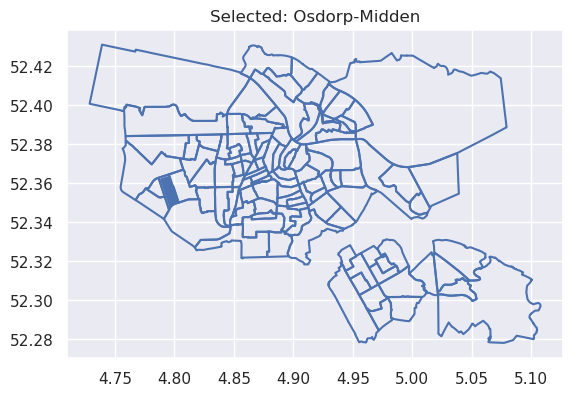

In [3]:
# Select area granularity (buurten/wijken/ggwgebieden/stadsdelen, https://api.data.amsterdam.nl/v1/docs/datasets/gebieden.html)
area_granularity = 'wijken'

# SELECT AREA
# district_name = 'Centrum'
# my_area = 'Nieuwmarkt/Lastage'
district_name = 'Nieuw-West'
my_area = 'Osdorp-Midden'

# Get area data
area_url = "https://api.data.amsterdam.nl/v1/gebieden/" + area_granularity
response_area = requests.get(url = area_url, params = {"_pageSize": 1000})
raw_data_area = response_area.json()['_embedded']
print(response_area.status_code)

# Create a proper GeoDataFrame with the area data
gdf_area = f.create_area_gdf(raw_data_area)
gdf_area = gdf_area.to_crs("EPSG:4326")
gdf_area_sel = gdf_area[gdf_area['naam'] == my_area]
area_polygon = gdf_area_sel.iloc[0]['geometry']

sns.set()
ax = gdf_area.boundary.plot()
ax = gdf_area_sel.plot(ax=ax)
plt.title('Selected: {}'.format(my_area))
plt.show()

In [4]:
# Retrieve polygon from selected area
polygon = gdf_area_sel.iloc[0]['geometry']

### Retrieve crossing features

In [5]:
# Retrieve crossing attributes
tags = {"crossing": True, "footway": 'crossing', "kerb": True}
crossing_features = ox.features_from_polygon(area_polygon, tags)

### Generate map and export crossing features

In [6]:
# Create tooltip for feature representation on map
def gen_tooltip(fields, aliases):

    tooltip = folium.GeoJsonTooltip(
        fields=fields,
        aliases=aliases,
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )
    return tooltip

# set True for satelite background, False for regular background
satelite = False

# Set folium map background
if satelite == True:
    network_color = 'white'
    tile = folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)
else:
    tile = 'openstreetmap'
    network_color = 'black'

# Create Folium map
map = folium.Map(
    location=[52.389164, 4.908453], tiles=tile,
    min_zoom=10, max_zoom=25, zoom_start=15,
    zoom_control=True, control_scale=True, control=False
    )

# Add crossing features
feature_names = crossing_features.columns.tolist()
feature_names.remove('geometry')
tooltip = gen_tooltip(feature_names, feature_names)
geo_j = folium.GeoJson(crossing_features, tooltip=tooltip, style_function=lambda x: {"color": "orange", "weight": 10}).add_to(map)

map

In [7]:
# Save crossing features as csv
crossing_features.to_csv(cf.out_folder + '/crossing_features/OpenStreetMap/crossing_features_osm_{}.csv'.format(my_area.replace('/', '-')))

# Save network with crossing features as html map
if satelite == True:
    map.save(cf.out_folder + '/crossing_features/OpenStreetMap/crossing_features_osm_' + my_area.replace('/', '-') + '_satelite.html')
else:
    map.save(cf.out_folder + '/crossing_features/OpenStreetMap/crossing_features_osm_' + my_area.replace('/', '-') + '.html')